In [48]:
#basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset,DataLoader
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from sklearn.model_selection import train_test_split
device = torch.device("mps")
import time
from sklearn.metrics import classification_report,accuracy_score
from tqdm import tqdm

In [2]:
df = pd.read_csv('/Users/aadityajoshi/Downloads/text.csv',index_col=0)
df = df.sample(frac=0.25)

In [3]:
#Six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).
df.head()

,text,label
138798,im still feeling positive,1
140720,i also loved the feeling of that gentle rippli...,2
368862,i feel like i will be getting a superior pork ...,1
326771,i hate feeling regretful,0
336056,i just feel so blessed,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104202 entries, 138798 to 346108
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    104202 non-null  object
 1   label   104202 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
#drop blanks and duplicates
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
blanks = []
for i,txt,lb in df.itertuples():
    if type(txt) == str:
        if txt.isspace() == True:
            blanks.append(i)
blanks

[]

### Exploring text from each emotion

In [6]:
em_dict = { "Sadness":0, "Joy" :1,"Love":2, "Anger":3, "Fear":4,"Suprise":5}
for k,v in em_dict.items():
    print(f"{k}","\n")
    for i in df[df['label'] == v]['text'][:2]:
        print(i)
    print("\n")

Sadness 

i hate feeling regretful
i don t know why but after that night i didn t feel so hopeless anymore


Joy 

im still feeling positive
i feel like i will be getting a superior pork product and bringing attention to neat breed


Love 

i also loved the feeling of that gentle rippling through the body when i floated in water it was a bonus having friends with pools growing up in australia
i was feeling pret t y tender let me tell you


Anger 

i was standing in a mumu outside my compound poking at a smoldering pile of trash with a stick being told by outsiders that i need to change what i m doing and feeling resentful as they drove away
i feel insulted as if he feels he doesn t have to work for my money anymore he can put out anything people will buy it and radio will find something to play just because its him


Fear 

i feel alarmed about his symptoms
i dont know why i feel less anxious when less people know about my tiny growing one but i do


Suprise 

i feel a strange serenity

<Axes: xlabel='label', ylabel='count'>

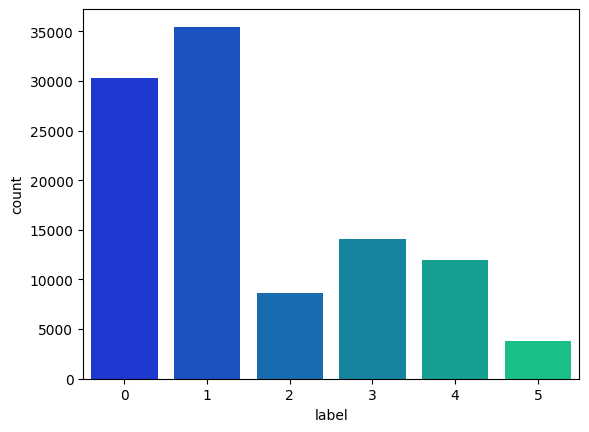

In [7]:
sns.countplot(x='label',data=df,palette='winter')

In [15]:
nlp = spacy.load('en_core_web_sm')
def clean_lemm(text):
    doc = nlp(text.lower())
    clean_text = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(clean_text)

In [16]:
df['text'] = df['text'].apply(clean_lemm)

In [30]:
df['len'] = df['text'].apply(len)

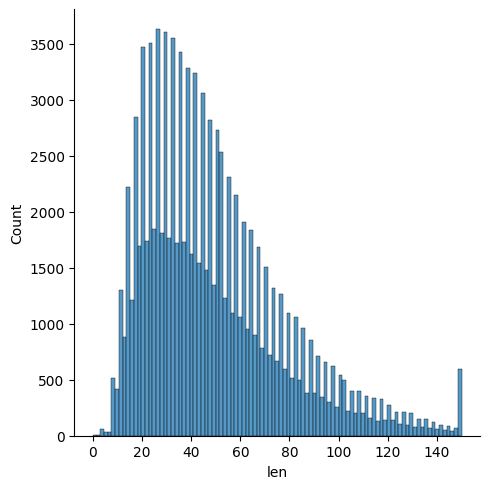

In [31]:
sns.displot(df['len'])

### Tfidf

In [19]:
tfidf = TfidfVectorizer(max_features=7500)
X = df['text']
y = df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [87]:
dtree = DecisionTreeClassifier()
start = time.time()
dtree.fit(X_train,y_train)
pred_dtree = dtree.predict(X_test)
print(classification_report(y_test,pred_dtree))
print(f"accuracy : {accuracy_score(y_test,pred_dtree)}")
print(f"{(time.time()-start)/60} mins")

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      6092
           1       0.86      0.86      0.86      7059
           2       0.71      0.67      0.69      1748
           3       0.82      0.84      0.83      2794
           4       0.80      0.81      0.80      2430
           5       0.68      0.67      0.68       708

    accuracy                           0.83     20831
   macro avg       0.79      0.79      0.79     20831
weighted avg       0.83      0.83      0.83     20831

accuracy : 0.8322692141519851
9.892061618963877 mins


In [108]:
rfc = RandomForestClassifier()
start = time.time()
rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)
print(classification_report(y_test,pred_rfc))
print(f"accuracy : {accuracy_score(y_test,pred_rfc)}")
print(f"Training Time : {(time.time()-start)/60} mins")

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6092
           1       0.88      0.90      0.89      7059
           2       0.78      0.67      0.72      1748
           3       0.86      0.87      0.86      2794
           4       0.82      0.84      0.83      2430
           5       0.70      0.70      0.70       708

    accuracy                           0.86     20831
   macro avg       0.82      0.81      0.82     20831
weighted avg       0.86      0.86      0.86     20831

accuracy : 0.8644808218520474
Training Time : 10.472678049405415 mins


In [28]:
nb = MultinomialNB()
start = time.time()
nb.fit(X_train,y_train)
pred_nb = nb.predict(X_test)
print(classification_report(y_test,pred_nb))
print(f"accuracy : {accuracy_score(y_test,pred_nb)}")
print(f"Training Time : {(time.time()-start)/60} mins")

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      6053
           1       0.76      0.97      0.85      6996
           2       0.96      0.36      0.52      1723
           3       0.93      0.74      0.82      2960
           4       0.90      0.67      0.77      2374
           5       0.99      0.22      0.37       725

    accuracy                           0.81     20831
   macro avg       0.89      0.65      0.70     20831
weighted avg       0.84      0.81      0.80     20831

accuracy : 0.814075176419759
Training Time : 0.058521366119384764 mins


### ANN with tfidf

In [58]:
X_train.shape

(83323, 7500)

In [61]:
class Model(nn.Module):
    def __init__(self,embedding_dim,h1=128,h2=64,h3=32,h4=16,out=6,dropout=0.2):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(embedding_dim,h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1,h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2,h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.fc4 = nn.Linear(h3,h4)
        self.bn4 = nn.BatchNorm1d(h4)
        self.out = nn.Linear(h4,out)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(self.bn2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(self.bn3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = F.relu(self.bn4(x))
        x = self.dropout(x)
        x = self.out(x)
        return F.log_softmax(x,dim=1)

In [94]:
model = Model(X_train.shape[1],dropout=0.4).to(device)

In [95]:
num_epochs = 500
optimizer_tf_ann = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    optimizer_tf_ann.zero_grad()
    loss.backward()
    optimizer_tf_ann.step()
    if (epoch+1) % 50 == 0:
        print(f"epoch : {epoch+1} loss : {loss.item()}")

epoch : 50 loss : 0.989723265171051
epoch : 100 loss : 0.6763586401939392
epoch : 150 loss : 0.5017480254173279
epoch : 200 loss : 0.40175798535346985
epoch : 250 loss : 0.3399790823459625


In [ ]:
model.eval()
with torch.no_grad():
    y_val = model(X_test)
#y_test = y_test.cpu().numpy()
y_val = torch.argmax(y_val,axis=1).cpu().numpy()
print(classification_report(y_test,y_val))

In [29]:
ind_len = list(df[df['len'] >= 150].index)
for i in ind_len:
    df['text'].loc[i] = df['text'].loc[i][:150]

In [32]:
#create vocab
def spacy_tokenizer(text):
    clean_text = clean_lemm(text)
    return clean_text.split()

In [33]:
def create_vocab(text_iterator,specials=("<pad>","<unk>"),min_freq=2):
    token_count = defaultdict(int)
    for text in text_iterator:
        for token in spacy_tokenizer(text):
            token_count[token]+=1
    vocab = {token:idx for idx,(token,count) in enumerate(token_count.items()) if count>=min_freq}
    for special in specials:
        if special not in vocab:
            vocab[special] = len(vocab)
    return vocab

In [34]:
vocab = create_vocab(df['text'])

In [35]:
vocab_size = len(vocab)

In [36]:
vocab_size

15239

In [37]:
text_pipeline = lambda x : [vocab.get(token,vocab["<unk>"]) for token in spacy_tokenizer(x)]
label_pipeline = lambda x : int(x)

In [38]:
#dataset
class TextDataset(Dataset):
    def __init__(self,df,text_pipeline,label_pipeline):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
    def __len__(self):
        return len(self.texts)
    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return text_pipeline(text),label_pipeline(label)

In [39]:
train_df,test_df = train_test_split(df,test_size=0.2,stratify=df['label'])

In [40]:
train_data = TextDataset(train_df,text_pipeline,label_pipeline)
test_data = TextDataset(test_df,text_pipeline,label_pipeline)

In [41]:
def pad_collate(batch):
    text_list = []
    label_list = []
    for text,label in batch:
        text_list.append(torch.tensor(text))
        label_list.append(label)
    text_list = pad_sequence(text_list,batch_first=True)
    label_list = torch.tensor(label_list)
    return text_list.to(device),label_list.to(device)

In [42]:
train_loader = DataLoader(train_data,batch_size=128,collate_fn=pad_collate)
test_loader = DataLoader(test_data,batch_size=128,collate_fn=pad_collate)

In [43]:
for x,y in train_loader:
    break

In [44]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,dropout,num_layers=1,bidirectional=False):
        super(LSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.num_dir = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.hidden_size*self.num_dir,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embedding = self.embedding(x)
        embedding = self.dropout(embedding)
        lstm_out,hidden = self.lstm(embedding,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device))
        return hidden

In [70]:
lstm = LSTM(vocab_size,128,32,6,0.3).to(device)

In [71]:
lstm

LSTM(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(15407, 128)
  (lstm): LSTM(128, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)

In [73]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(),lr=0.001)

In [75]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    lstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = lstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 651/651 [01:59<00:00,  5.45it/s, loss=1.2710]


Epoch 1/5, Average Loss: 1.5019


Epoch 2/5: 100%|█████████████████| 651/651 [02:01<00:00,  5.36it/s, loss=0.8245]


Epoch 2/5, Average Loss: 0.9981


Epoch 3/5: 100%|█████████████████| 651/651 [02:03<00:00,  5.29it/s, loss=0.6296]


Epoch 3/5, Average Loss: 0.6104


Epoch 4/5: 100%|█████████████████| 651/651 [02:02<00:00,  5.31it/s, loss=0.5644]


Epoch 4/5, Average Loss: 0.4336


Epoch 5/5: 100%|█████████████████| 651/651 [02:02<00:00,  5.31it/s, loss=0.4288]

Epoch 5/5, Average Loss: 0.3498
Total training time: 10.16 minutes


In [82]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []
  
lstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = lstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))
print(f"accuracy : {accuracy_score(all_labels,all_preds)}")

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      6054
           1       0.92      0.93      0.92      7093
           2       0.74      0.68      0.71      1720
           3       0.89      0.94      0.91      2824
           4       0.92      0.83      0.87      2383
           5       0.79      0.65      0.71       757

    accuracy                           0.90     20831
   macro avg       0.86      0.83      0.85     20831
weighted avg       0.90      0.90      0.90     20831

accuracy : 0.8989486822524123


### Multilayer LSTM

In [89]:
class LSTM(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,dropout,num_layers=2,bidirectional=False):
        super(LSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.num_dir = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.hidden_size*self.num_dir,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embedding = self.embedding(x)
        embedding = self.dropout(embedding)
        lstm_out,hidden = self.lstm(embedding,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device))
        return hidden

In [93]:
lstm_2 = LSTM(vocab_size,128,64,6,0.2).to(device)

In [94]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_2.parameters(),lr=0.005)
start = time.time()
for epoch in range(num_epochs):
    lstm_2.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = lstm_2(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 651/651 [02:05<00:00,  5.19it/s, loss=1.4774]


Epoch 1/5, Average Loss: 1.5765


Epoch 2/5: 100%|█████████████████| 651/651 [02:04<00:00,  5.21it/s, loss=0.3788]


Epoch 2/5, Average Loss: 0.9731


Epoch 3/5: 100%|█████████████████| 651/651 [02:03<00:00,  5.28it/s, loss=0.3101]


Epoch 3/5, Average Loss: 0.2345


Epoch 4/5: 100%|█████████████████| 651/651 [02:05<00:00,  5.17it/s, loss=0.2415]


Epoch 4/5, Average Loss: 0.1707


Epoch 5/5: 100%|█████████████████| 651/651 [02:04<00:00,  5.24it/s, loss=0.1771]

Epoch 5/5, Average Loss: 0.1522
Total training time: 10.40 minutes


In [95]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []
  
lstm_2.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = lstm_2(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))
print(f"accuracy : {accuracy_score(all_labels,all_preds)}")

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      6054
           1       0.96      0.91      0.94      7093
           2       0.77      0.89      0.83      1720
           3       0.95      0.91      0.93      2824
           4       0.84      0.95      0.89      2383
           5       0.86      0.71      0.78       757

    accuracy                           0.92     20831
   macro avg       0.89      0.89      0.89     20831
weighted avg       0.92      0.92      0.92     20831

accuracy : 0.9203590802169843


### BILSTM

In [97]:
class BILSTM(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,dropout,num_layers=2,bidirectional=True):
        super(BILSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.num_dir = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.hidden_size*self.num_dir,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embedding = self.embedding(x)
        embedding = self.dropout(embedding)
        lstm_out,hidden = self.lstm(embedding,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device))
        return hidden

In [102]:
bilstm = BILSTM(vocab_size,128,64,6,0.2).to(device)

In [106]:
num_epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bilstm.parameters(),lr=0.005)
start = time.time()
for epoch in range(num_epochs):
    bilstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = bilstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/2: 100%|█████████████████| 651/651 [02:28<00:00,  4.37it/s, loss=0.1723]


Epoch 1/2, Average Loss: 0.1489


Epoch 2/2: 100%|█████████████████| 651/651 [02:47<00:00,  3.88it/s, loss=0.1901]

Epoch 2/2, Average Loss: 0.1368
Total training time: 5.28 minutes


In [107]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []
  
bilstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = bilstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))
print(f"accuracy : {accuracy_score(all_labels,all_preds)}")

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      6054
           1       0.93      0.94      0.94      7093
           2       0.83      0.81      0.82      1720
           3       0.97      0.89      0.93      2824
           4       0.83      0.96      0.89      2383
           5       0.86      0.70      0.77       757

    accuracy                           0.92     20831
   macro avg       0.90      0.88      0.88     20831
weighted avg       0.92      0.92      0.92     20831

accuracy : 0.9196870049445538


### GRU

In [45]:
class GRU(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,dropout,num_layers=2,bidirectional=False):
        super(GRU,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.num_dir = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.hidden_size*self.num_dir,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embedding = self.embedding(x)
        embedding = self.dropout(embedding)
        gru_out,hidden = self.gru(embedding,hidden)
        gru_out = self.dropout(gru_out)
        pred = self.fc(gru_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device))
        return hidden

In [46]:
Gru = GRU(vocab_size,128,64,6,0.2).to(device)

In [50]:
num_epochs = 7
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Gru.parameters(),lr=0.0025)
start = time.time()
for epoch in range(num_epochs):
    Gru.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = Gru(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

Epoch 1/7: 100%|█████████████████| 651/651 [02:18<00:00,  4.71it/s, loss=0.2569]


Epoch 1/7, Average Loss: 0.6118


Epoch 2/7: 100%|█████████████████| 651/651 [02:19<00:00,  4.66it/s, loss=0.2006]


Epoch 2/7, Average Loss: 0.1994


Epoch 3/7: 100%|█████████████████| 651/651 [02:20<00:00,  4.63it/s, loss=0.1244]


Epoch 3/7, Average Loss: 0.1622


Epoch 4/7: 100%|█████████████████| 651/651 [02:20<00:00,  4.64it/s, loss=0.1255]


Epoch 4/7, Average Loss: 0.1454


Epoch 5/7: 100%|█████████████████| 651/651 [02:19<00:00,  4.67it/s, loss=0.1056]


Epoch 5/7, Average Loss: 0.1340


Epoch 6/7: 100%|█████████████████| 651/651 [02:19<00:00,  4.68it/s, loss=0.0961]


Epoch 6/7, Average Loss: 0.1262


Epoch 7/7: 100%|█████████████████| 651/651 [02:18<00:00,  4.69it/s, loss=0.1449]

Epoch 7/7, Average Loss: 0.1193


In [51]:
from sklearn.metrics import classification_report,accuracy_score
all_preds = []
all_labels = []
  
Gru.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = Gru(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))
print(f"accuracy : {accuracy_score(all_labels,all_preds)}")

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      6065
           1       0.91      0.96      0.94      7046
           2       0.88      0.71      0.79      1727
           3       0.93      0.93      0.93      2865
           4       0.87      0.91      0.89      2384
           5       0.84      0.74      0.79       744

    accuracy                           0.92     20831
   macro avg       0.90      0.87      0.88     20831
weighted avg       0.92      0.92      0.92     20831

accuracy : 0.9180068167634775


### BIGRU

In [53]:
class BIGRU(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,dropout,num_layers=2,bidirectional=True):
        super(BIGRU,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.num_dir = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.hidden_size*self.num_dir,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embedding = self.embedding(x)
        embedding = self.dropout(embedding)
        gru_out,hidden = self.gru(embedding,hidden)
        gru_out = self.dropout(gru_out)
        pred = self.fc(gru_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_layers*self.num_dir,batch_size,self.hidden_size).to(device))
        return hidden

In [54]:
bigru = BIGRU(vocab_size,128,64,6,0.2).to(device)

In [55]:
num_epochs = 7
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bigru.parameters(),lr=0.0025)
start = time.time()
for epoch in range(num_epochs):
    bigru.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = bigru(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

Epoch 1/7: 100%|█████████████████| 651/651 [02:41<00:00,  4.04it/s, loss=0.2872]


Epoch 1/7, Average Loss: 0.6747


Epoch 2/7: 100%|█████████████████| 651/651 [02:41<00:00,  4.03it/s, loss=0.1791]


Epoch 2/7, Average Loss: 0.1949


Epoch 3/7: 100%|█████████████████| 651/651 [02:38<00:00,  4.11it/s, loss=0.1611]


Epoch 3/7, Average Loss: 0.1580


Epoch 4/7: 100%|█████████████████| 651/651 [02:39<00:00,  4.07it/s, loss=0.1137]


Epoch 4/7, Average Loss: 0.1397


Epoch 5/7: 100%|█████████████████| 651/651 [02:40<00:00,  4.07it/s, loss=0.1376]


Epoch 5/7, Average Loss: 0.1309


Epoch 6/7: 100%|█████████████████| 651/651 [02:39<00:00,  4.08it/s, loss=0.1057]


Epoch 6/7, Average Loss: 0.1205


Epoch 7/7: 100%|█████████████████| 651/651 [02:40<00:00,  4.05it/s, loss=0.1135]

Epoch 7/7, Average Loss: 0.1146
